# 07b 现代创新架构：Inception 与 DenseNet

> 多尺度特征提取与密集连接：两种不同的架构创新思路

---

**本章重点**：理解 Inception 的多分支并行设计和 DenseNet 的特征复用思想。

## 📚 学习目标

- [ ] 理解 Inception 模块的多尺度设计思想
- [ ] **掌握 1×1 卷积的降维作用**
- [ ] **实现 Inception 模块**
- [ ] 理解 DenseNet 的密集连接原理
- [ ] **掌握 Dense Block 和 Transition Layer 的设计**
- [ ] 对比 ResNet 和 DenseNet 的连接方式

## 🔍 前置知识

在开始之前，请确保你已经掌握：

- **07_classic_architectures.ipynb** - ResNet 残差连接
- **07a_lenet_alexnet_vgg.ipynb** - 早期架构演进

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

使用设备: cpu


---

# 架构创新的两个方向

在 VGGNet 之后，研究者们探索了两种不同的架构创新方向：

```
VGGNet (2014)
     │
     ├────────────────────┬────────────────────┐
     │                    │                    │
     ↓                    ↓                    ↓
  GoogLeNet           ResNet               DenseNet
  (Inception)         (2015)               (2017)
  (2014)                │                    │
     │              残差连接              密集连接
 多尺度并行          (加法)               (拼接)
     │                    │                    │
     └────────────────────┴────────────────────┘
                          │
                     现代架构
```

本章将深入讲解 **Inception** 和 **DenseNet** 两种创新设计。

---

# Part 1: GoogLeNet/Inception (2014)

## 1.1 设计动机

VGGNet 统一使用 3×3 卷积，但这引发了一个问题：

> **如何选择卷积核大小？1×1、3×3、还是 5×5？**

GoogLeNet 的回答是：**全都要！**

不同大小的卷积核可以捕获不同尺度的特征：
- **1×1**: 点级特征，通道间信息融合
- **3×3**: 小局部特征
- **5×5**: 较大局部特征
- **池化**: 保留主要信息，增加感受野

## 1.2 朴素 Inception 模块

最初的想法很简单：并行执行多种卷积，然后拼接结果。

```
                     输入 (C, H, W)
                          │
        ┌─────────┬───────┴───────┬─────────┐
        │         │               │         │
        ↓         ↓               ↓         ↓
      1×1       3×3             5×5      MaxPool
      Conv      Conv            Conv      3×3
        │         │               │         │
        ↓         ↓               ↓         ↓
     (C1,H,W)  (C3,H,W)        (C5,H,W)  (C,H,W)
        │         │               │         │
        └─────────┴───────┬───────┴─────────┘
                          │
                       Concat
                          │
                          ↓
                 (C1+C3+C5+C, H, W)
```

**问题**：5×5 卷积计算量太大！

例如：输入 (256, 28, 28)，用 128 个 5×5 卷积核
- 计算量：256 × 128 × 5 × 5 × 28 × 28 ≈ **6.4 亿次** 乘法

## 1.3 1×1 卷积降维

解决方案：在 3×3 和 5×5 卷积之前，先用 **1×1 卷积降维**。

```
                     输入 (C, H, W)
                          │
        ┌─────────┬───────┴───────┬─────────┐
        │         │               │         │
        ↓         ↓               ↓         ↓
      1×1       1×1             1×1      MaxPool
      Conv     降维             降维       3×3
        │         │               │         │
        │         ↓               ↓         ↓
        │       3×3             5×5       1×1
        │       Conv            Conv      Conv
        │         │               │         │
        ↓         ↓               ↓         ↓
     (C1,H,W)  (C3,H,W)        (C5,H,W)  (Cp,H,W)
        │         │               │         │
        └─────────┴───────┬───────┴─────────┘
                          │
                       Concat
                          │
                          ↓
                  (C1+C3+C5+Cp, H, W)
```

**计算量对比**（输入 256 通道，降维到 32 通道，再用 5×5 输出 128 通道）：

- 原始：256 × 128 × 5 × 5 × 28 × 28 ≈ **6.4 亿**
- 降维后：256 × 32 × 1 × 1 × 28 × 28 + 32 × 128 × 5 × 5 × 28 × 28 ≈ **0.8 亿**

**节省约 8 倍计算量！**

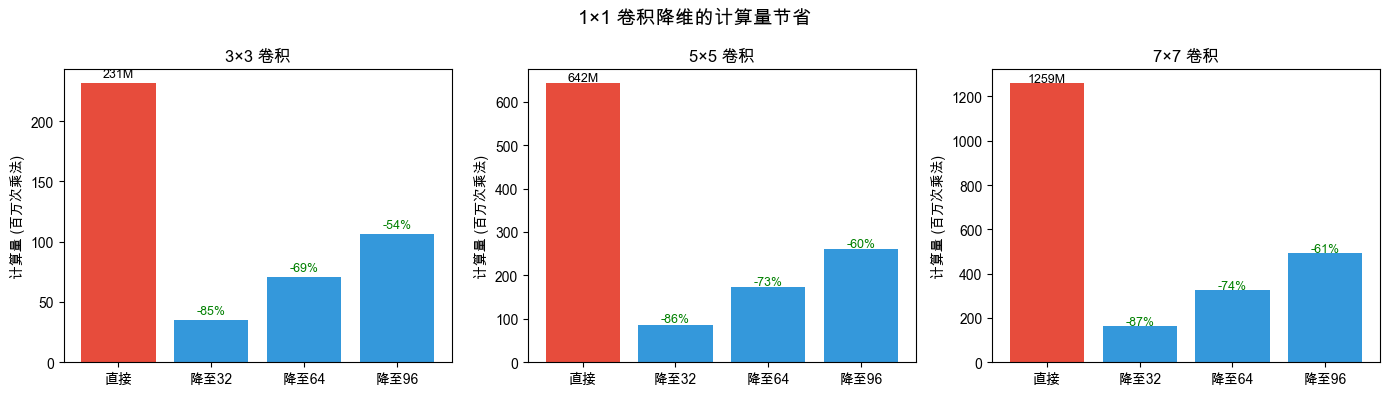

💡 关键发现：
   - 1×1 卷积可以大幅降低计算量
   - 对于 5×5 和 7×7 卷积效果尤为明显
   - 这是 Inception 模块的核心优化


In [2]:
# 可视化 1×1 卷积降维效果

def compute_ops(in_ch, out_ch, kernel_size, spatial_size, reduce_ch=None):
    """计算卷积操作数（乘法次数）"""
    H, W = spatial_size
    if reduce_ch is None:
        # 直接卷积
        return in_ch * out_ch * kernel_size * kernel_size * H * W
    else:
        # 1×1 降维 + 卷积
        ops_1x1 = in_ch * reduce_ch * 1 * 1 * H * W
        ops_conv = reduce_ch * out_ch * kernel_size * kernel_size * H * W
        return ops_1x1 + ops_conv

# 参数设置
in_ch = 256
out_ch = 128
spatial = (28, 28)

# 对比不同核大小
kernels = [3, 5, 7]
reduce_channels = [32, 64, 96]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, k in enumerate(kernels):
    ops_direct = compute_ops(in_ch, out_ch, k, spatial) / 1e6
    ops_reduced = [compute_ops(in_ch, out_ch, k, spatial, r) / 1e6 for r in reduce_channels]
    
    x = ['直接'] + [f'降至{r}' for r in reduce_channels]
    y = [ops_direct] + ops_reduced
    
    colors = ['#e74c3c'] + ['#3498db'] * len(reduce_channels)
    bars = axes[idx].bar(x, y, color=colors)
    axes[idx].set_ylabel('计算量 (百万次乘法)')
    axes[idx].set_title(f'{k}×{k} 卷积')
    
    # 标注节省比例
    for i, (bar, val) in enumerate(zip(bars, y)):
        if i == 0:
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                          f'{val:.0f}M', ha='center', fontsize=9)
        else:
            ratio = (1 - val / ops_direct) * 100
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                          f'-{ratio:.0f}%', ha='center', fontsize=9, color='green')

plt.suptitle('1×1 卷积降维的计算量节省', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 关键发现：")
print("   - 1×1 卷积可以大幅降低计算量")
print("   - 对于 5×5 和 7×7 卷积效果尤为明显")
print("   - 这是 Inception 模块的核心优化")

## 1.4 PyTorch 实现 Inception 模块

In [3]:
class InceptionModule(nn.Module):
    """
    Inception 模块 - GoogLeNet 的核心构建块
    
    结构:
        输入 ──┬── 1×1 Conv ────────────────────┐
               ├── 1×1 Conv → 3×3 Conv ────────┤
               ├── 1×1 Conv → 5×5 Conv ────────┼── Concat → 输出
               └── MaxPool 3×3 → 1×1 Conv ─────┘
    
    参数:
        in_channels: 输入通道数
        ch1x1: 第一分支 1×1 卷积输出通道数
        ch3x3_reduce: 第二分支 1×1 降维通道数
        ch3x3: 第二分支 3×3 卷积输出通道数
        ch5x5_reduce: 第三分支 1×1 降维通道数
        ch5x5: 第三分支 5×5 卷积输出通道数
        pool_proj: 第四分支池化后 1×1 投影通道数
    
    输出通道数 = ch1x1 + ch3x3 + ch5x5 + pool_proj
    """
    
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3,
                 ch5x5_reduce, ch5x5, pool_proj):
        super().__init__()
        
        # ========================================
        # 分支 1: 1×1 卷积
        # 直接进行通道变换，不改变空间尺寸
        # ========================================
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )
        
        # ========================================
        # 分支 2: 1×1 降维 → 3×3 卷积
        # 先降维减少计算量，再提取 3×3 局部特征
        # ========================================
        self.branch2 = nn.Sequential(
            # 1×1 降维
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(ch3x3_reduce),
            nn.ReLU(inplace=True),
            # 3×3 卷积（padding=1 保持尺寸）
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )
        
        # ========================================
        # 分支 3: 1×1 降维 → 5×5 卷积
        # 先降维减少计算量，再提取 5×5 较大局部特征
        # ========================================
        self.branch3 = nn.Sequential(
            # 1×1 降维
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(ch5x5_reduce),
            nn.ReLU(inplace=True),
            # 5×5 卷积（padding=2 保持尺寸）
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )
        
        # ========================================
        # 分支 4: 3×3 MaxPool → 1×1 投影
        # 池化保留主要信息，1×1 调整通道数
        # ========================================
        self.branch4 = nn.Sequential(
            # 3×3 MaxPool（padding=1 保持尺寸）
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            # 1×1 投影
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """
        前向传播：并行计算四个分支，然后在通道维度拼接
        
        参数:
            x: (batch, in_channels, H, W)
        
        返回:
            out: (batch, ch1x1 + ch3x3 + ch5x5 + pool_proj, H, W)
        """
        # 并行计算四个分支
        out1 = self.branch1(x)  # (batch, ch1x1, H, W)
        out2 = self.branch2(x)  # (batch, ch3x3, H, W)
        out3 = self.branch3(x)  # (batch, ch5x5, H, W)
        out4 = self.branch4(x)  # (batch, pool_proj, H, W)
        
        # 在通道维度（dim=1）拼接
        out = torch.cat([out1, out2, out3, out4], dim=1)
        
        return out


# 测试 Inception 模块
# 使用 GoogLeNet 中 Inception 3a 的配置
inception = InceptionModule(
    in_channels=192,
    ch1x1=64,
    ch3x3_reduce=96, ch3x3=128,
    ch5x5_reduce=16, ch5x5=32,
    pool_proj=32
)

x = torch.randn(1, 192, 28, 28)
y = inception(x)

print("Inception 模块测试：")
print(f"  输入: {x.shape}")
print(f"  输出: {y.shape}")
print(f"  输出通道数: 64 + 128 + 32 + 32 = {64 + 128 + 32 + 32}")
print(f"  参数量: {sum(p.numel() for p in inception.parameters()):,}")

Inception 模块测试：
  输入: torch.Size([1, 192, 28, 28])
  输出: torch.Size([1, 256, 28, 28])
  输出通道数: 64 + 128 + 32 + 32 = 256
  参数量: 164,432


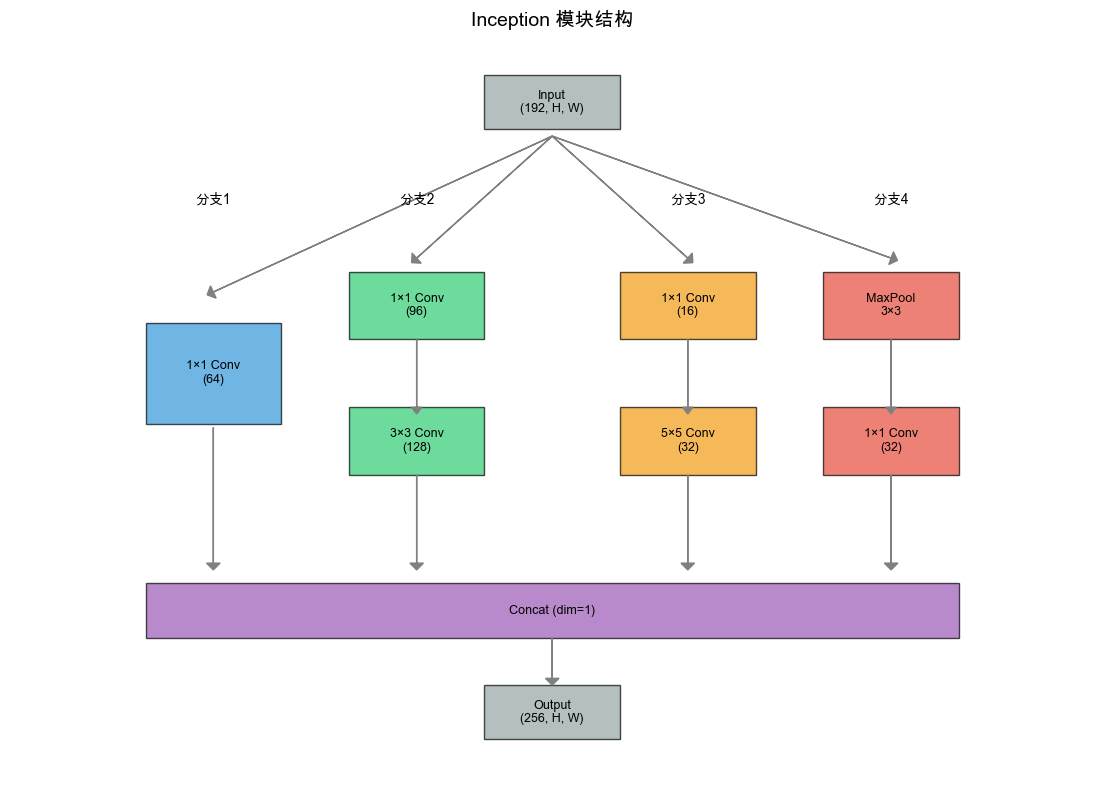

In [4]:
# 可视化 Inception 模块结构

fig, ax = plt.subplots(figsize=(14, 8))

# 绘制模块结构
def draw_box(ax, x, y, w, h, text, color='steelblue'):
    rect = plt.Rectangle((x - w/2, y - h/2), w, h,
                          facecolor=color, edgecolor='black', alpha=0.7)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

# 输入
draw_box(ax, 7, 9, 2, 0.8, 'Input\n(192, H, W)', '#95a5a6')

# 四个分支
branches_x = [2, 5, 9, 12]
branch_colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
branch_texts = [
    ['1×1 Conv\n(64)'],
    ['1×1 Conv\n(96)', '3×3 Conv\n(128)'],
    ['1×1 Conv\n(16)', '5×5 Conv\n(32)'],
    ['MaxPool\n3×3', '1×1 Conv\n(32)']
]

# 绘制分支
for bx, color, texts in zip(branches_x, branch_colors, branch_texts):
    if len(texts) == 1:
        draw_box(ax, bx, 5, 2, 1.5, texts[0], color)
        ax.arrow(7, 8.5, bx - 7, -2.3, head_width=0.2, head_length=0.1, fc='gray', ec='gray')
        ax.arrow(bx, 4.2, 0, -2, head_width=0.2, head_length=0.1, fc='gray', ec='gray')
    else:
        draw_box(ax, bx, 6, 2, 1, texts[0], color)
        draw_box(ax, bx, 4, 2, 1, texts[1], color)
        ax.arrow(7, 8.5, bx - 7, -1.8, head_width=0.2, head_length=0.1, fc='gray', ec='gray')
        ax.arrow(bx, 5.5, 0, -1, head_width=0.15, head_length=0.1, fc='gray', ec='gray')
        ax.arrow(bx, 3.5, 0, -1.3, head_width=0.2, head_length=0.1, fc='gray', ec='gray')

# Concat
draw_box(ax, 7, 1.5, 12, 0.8, 'Concat (dim=1)', '#9b59b6')

# 输出
draw_box(ax, 7, 0, 2, 0.8, 'Output\n(256, H, W)', '#95a5a6')
ax.arrow(7, 1.1, 0, -0.6, head_width=0.2, head_length=0.1, fc='gray', ec='gray')

# 分支标签
ax.text(2, 7.5, '分支1', ha='center', fontsize=10)
ax.text(5, 7.5, '分支2', ha='center', fontsize=10)
ax.text(9, 7.5, '分支3', ha='center', fontsize=10)
ax.text(12, 7.5, '分支4', ha='center', fontsize=10)

ax.set_xlim(-1, 15)
ax.set_ylim(-1, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Inception 模块结构', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 1.5 简化版 GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
    """
    GoogLeNet 简化版实现
    
    原版有 22 层，包含 9 个 Inception 模块。
    这里实现一个适合 CIFAR-10 的简化版本。
    """
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # ========================================
        # Stem: 初始卷积层
        # ========================================
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 → 16
        )
        
        # ========================================
        # Inception 模块组
        # ========================================
        # Inception 3a: 64 → 256
        self.inception3a = InceptionModule(64, 32, 48, 64, 8, 16, 16)
        # 输出: 32 + 64 + 16 + 16 = 128
        
        # Inception 3b: 128 → 256
        self.inception3b = InceptionModule(128, 64, 64, 96, 16, 48, 32)
        # 输出: 64 + 96 + 48 + 32 = 240
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16 → 8
        
        # Inception 4a: 240 → 256
        self.inception4a = InceptionModule(240, 96, 48, 104, 8, 24, 32)
        # 输出: 96 + 104 + 24 + 32 = 256
        
        # Inception 4b: 256 → 288
        self.inception4b = InceptionModule(256, 80, 56, 112, 12, 32, 32)
        # 输出: 80 + 112 + 32 + 32 = 256
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 8 → 4
        
        # Inception 5a: 256 → 256
        self.inception5a = InceptionModule(256, 112, 72, 144, 16, 32, 32)
        # 输出: 112 + 144 + 32 + 32 = 320
        
        # ========================================
        # 分类头
        # ========================================
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(320, num_classes)
    
    def forward(self, x):
        # Stem
        x = self.stem(x)          # (batch, 64, 16, 16)
        
        # Inception 3
        x = self.inception3a(x)   # (batch, 128, 16, 16)
        x = self.inception3b(x)   # (batch, 240, 16, 16)
        x = self.pool1(x)         # (batch, 240, 8, 8)
        
        # Inception 4
        x = self.inception4a(x)   # (batch, 256, 8, 8)
        x = self.inception4b(x)   # (batch, 256, 8, 8)
        x = self.pool2(x)         # (batch, 256, 4, 4)
        
        # Inception 5
        x = self.inception5a(x)   # (batch, 320, 4, 4)
        
        # 分类头
        x = self.avgpool(x)       # (batch, 320, 1, 1)
        x = x.view(x.size(0), -1) # (batch, 320)
        x = self.dropout(x)
        x = self.fc(x)            # (batch, num_classes)
        
        return x


# 测试 GoogLeNet
googlenet = GoogLeNet(num_classes=10)
x = torch.randn(1, 3, 32, 32)
y = googlenet(x)

print("GoogLeNet 测试：")
print(f"  输入: {x.shape}")
print(f"  输出: {y.shape}")
print(f"  参数量: {sum(p.numel() for p in googlenet.parameters()):,}")

## 1.6 Inception 演进

Inception 架构经历了多个版本的演进：

| 版本 | 年份 | 主要改进 |
|------|------|----------|
| **Inception V1** (GoogLeNet) | 2014 | 多尺度并行 + 1×1 降维 |
| **Inception V2** | 2015 | 加入 Batch Normalization |
| **Inception V3** | 2015 | 分解卷积（5×5 → 3×3 + 3×3）|
| **Inception V4** | 2016 | 更统一的设计 |
| **Inception-ResNet** | 2016 | 结合残差连接 |

In [ ]:
# 使用 torchvision 预训练模型

from torchvision.models import inception_v3, Inception_V3_Weights

print("加载预训练 Inception V3...")
inception_v3_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
inception_v3_model.eval()

print(f"参数量: {sum(p.numel() for p in inception_v3_model.parameters()):,}")

# 注意：Inception V3 需要 299×299 输入
x = torch.randn(1, 3, 299, 299)
with torch.no_grad():
    output = inception_v3_model(x)
print(f"输入: {x.shape}")
print(f"输出: {output.shape}")

## 1.7 Inception 小结

**核心贡献**：
1. **多尺度特征提取**：并行使用不同大小的卷积核
2. **1×1 卷积降维**：大幅减少计算量
3. **稀疏到密集**：用密集操作近似稀疏结构

**局限性**：
- 模块设计复杂，手工调参工作量大
- 不同分支的通道数需要仔细设计
- 辅助分类器增加训练复杂度

---

# Part 2: DenseNet (2017)

## 2.1 密集连接的思想

DenseNet 的核心思想非常简洁：

> **将每一层与其后的所有层直接连接**

对比 ResNet 的残差连接（跳一层）：

```
ResNet 残差连接:                   DenseNet 密集连接:

Layer 1 ──────┐                   Layer 1 ───┬───┬───┬───→
    ↓         │                       ↓      │   │   │
Layer 2 ──────┼───┐               Layer 2 ───┼───┼───┼───→
    ↓         │   │                   ↓      │   │   │
Layer 3 ←─────┘   │               Layer 3 ───┼───┼───┼───→
    ↓             │                   ↓      │   │   │
Layer 4 ←─────────┘               Layer 4 ←──┴───┴───┴───

   每层只连接                        每层连接到
   前一层                            所有之前的层
```

## 2.2 加法 vs 拼接

ResNet 和 DenseNet 的关键区别：

| | ResNet | DenseNet |
|---|--------|----------|
| **连接方式** | 相加 (element-wise sum) | 拼接 (concatenation) |
| **公式** | $x_l = H_l(x_{l-1}) + x_{l-1}$ | $x_l = H_l([x_0, x_1, ..., x_{l-1}])$ |
| **通道数** | 保持不变 | 逐层增加 |
| **特征复用** | 隐式（加法融合）| 显式（保留原始特征）|

拼接的优势：
- 保留了所有之前层的原始特征
- 每层可以直接访问梯度（类似于隐式的深度监督）
- 鼓励特征复用，减少冗余

In [ ]:
# 可视化 ResNet vs DenseNet 连接方式

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ResNet 连接
ax = axes[0]
layers_y = [4, 3, 2, 1]
for i, y in enumerate(layers_y):
    rect = plt.Rectangle((1, y - 0.3), 2, 0.6, facecolor='#3498db', edgecolor='black')
    ax.add_patch(rect)
    ax.text(2, y, f'Layer {i+1}', ha='center', va='center', fontsize=10, color='white')

# 残差连接（每隔一层）
ax.annotate('', xy=(3.2, 3), xytext=(3.2, 4),
            arrowprops=dict(arrowstyle='->', color='gray', lw=2))
ax.annotate('', xy=(3.5, 2), xytext=(3.5, 4),
            arrowprops=dict(arrowstyle='->', color='red', lw=2, ls='--'))
ax.annotate('', xy=(3.2, 1), xytext=(3.2, 2),
            arrowprops=dict(arrowstyle='->', color='gray', lw=2))

ax.text(4, 3, '+', fontsize=20, color='red')
ax.text(4, 1, '+', fontsize=20, color='red')

ax.set_xlim(0, 6)
ax.set_ylim(0, 5)
ax.set_title('ResNet: 残差连接 (相加)', fontsize=12, fontweight='bold')
ax.axis('off')

# DenseNet 连接
ax = axes[1]
for i, y in enumerate(layers_y):
    rect = plt.Rectangle((1, y - 0.3), 2, 0.6, facecolor='#e74c3c', edgecolor='black')
    ax.add_patch(rect)
    ax.text(2, y, f'Layer {i+1}', ha='center', va='center', fontsize=10, color='white')

# 密集连接（每层连接到所有后续层）
colors = ['#2ecc71', '#3498db', '#f39c12', '#9b59b6']
for i in range(4):
    for j in range(i + 1, 4):
        x_offset = 3.2 + (j - i - 1) * 0.3
        ax.annotate('', xy=(x_offset, layers_y[j]), xytext=(x_offset, layers_y[i]),
                    arrowprops=dict(arrowstyle='->', color=colors[i], lw=1.5, alpha=0.7))

# Concat 符号
for y in layers_y[1:]:
    ax.text(4.5, y, 'cat', fontsize=10, color='#e74c3c')

ax.set_xlim(0, 6)
ax.set_ylim(0, 5)
ax.set_title('DenseNet: 密集连接 (拼接)', fontsize=12, fontweight='bold')
ax.axis('off')

plt.suptitle('ResNet vs DenseNet 连接方式对比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 关键区别：")
print("   - ResNet: 相加融合特征，通道数不变")
print("   - DenseNet: 拼接保留特征，通道数逐层增加")

## 2.3 DenseNet 核心概念

### Growth Rate (增长率 k)

每层新增的通道数。例如 k=32 表示每层输出 32 个新特征图。

第 l 层的输入通道数 = $k_0 + k \times (l - 1)$

其中 $k_0$ 是初始通道数。

### Dense Block (密集块)

一组连续的密集连接层。块内每层都连接到之前的所有层。

### Transition Layer (过渡层)

连接两个 Dense Block，负责：
1. 降低通道数（1×1 卷积）
2. 降低空间尺寸（2×2 平均池化）

In [ ]:
class DenseLayer(nn.Module):
    """
    DenseNet 中的单个密集层
    
    结构（DenseNet-BC 风格）:
        BN → ReLU → Conv 1×1 (bottleneck) → BN → ReLU → Conv 3×3
    
    参数:
        in_channels: 输入通道数（累积了之前所有层的输出）
        growth_rate: 增长率 k，本层输出的新特征图数量
        bn_size: bottleneck 的扩展因子，1×1 卷积输出 bn_size * k 通道
    """
    
    def __init__(self, in_channels, growth_rate, bn_size=4):
        super().__init__()
        
        # Bottleneck 中间层通道数
        inter_channels = bn_size * growth_rate
        
        # ========================================
        # Bottleneck: 1×1 卷积降维
        # 输入可能有很多通道，先压缩到 inter_channels
        # ========================================
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1, bias=False)
        
        # ========================================
        # 3×3 卷积提取特征
        # 输出固定为 growth_rate 通道
        # ========================================
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, growth_rate, kernel_size=3, padding=1, bias=False)
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: (batch, in_channels, H, W) 累积的特征
        
        返回:
            new_features: (batch, growth_rate, H, W) 新生成的特征
        """
        # Bottleneck
        out = self.conv1(F.relu(self.bn1(x)))
        
        # 3×3 卷积
        out = self.conv2(F.relu(self.bn2(out)))
        
        return out


class DenseBlock(nn.Module):
    """
    DenseNet 的密集块
    
    包含多个 DenseLayer，每层的输入是之前所有层输出的拼接。
    
    参数:
        num_layers: 块中的层数
        in_channels: 输入通道数
        growth_rate: 增长率 k
        bn_size: bottleneck 扩展因子
    """
    
    def __init__(self, num_layers, in_channels, growth_rate, bn_size=4):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        for i in range(num_layers):
            # 每层的输入通道 = 初始通道 + 之前所有层的输出
            layer_in_channels = in_channels + i * growth_rate
            layer = DenseLayer(layer_in_channels, growth_rate, bn_size)
            self.layers.append(layer)
    
    def forward(self, x):
        """
        前向传播
        
        关键：每层输出与所有之前的特征拼接
        """
        features = [x]  # 存储所有特征
        
        for layer in self.layers:
            # 拼接之前所有特征作为输入
            concat_features = torch.cat(features, dim=1)
            # 生成新特征
            new_features = layer(concat_features)
            # 添加到特征列表
            features.append(new_features)
        
        # 返回所有特征的拼接
        return torch.cat(features, dim=1)


class Transition(nn.Module):
    """
    过渡层：连接两个 Dense Block
    
    功能:
        1. 1×1 卷积压缩通道（compression）
        2. 2×2 平均池化降低空间尺寸
    
    参数:
        in_channels: 输入通道数
        out_channels: 输出通道数（通常 = in_channels * compression）
    """
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.pool(out)
        return out


# 测试组件
print("DenseNet 组件测试：")

# DenseLayer
layer = DenseLayer(in_channels=64, growth_rate=32)
x = torch.randn(1, 64, 8, 8)
y = layer(x)
print(f"  DenseLayer: {x.shape} → {y.shape}")

# DenseBlock
block = DenseBlock(num_layers=4, in_channels=64, growth_rate=32)
x = torch.randn(1, 64, 8, 8)
y = block(x)
print(f"  DenseBlock(4层): {x.shape} → {y.shape}")
print(f"    输出通道 = 64 + 4×32 = {64 + 4*32}")

# Transition
trans = Transition(in_channels=192, out_channels=96)
x = torch.randn(1, 192, 8, 8)
y = trans(x)
print(f"  Transition: {x.shape} → {y.shape}")

## 2.4 完整 DenseNet 实现

In [ ]:
class DenseNet(nn.Module):
    """
    DenseNet 完整实现
    
    结构:
        Conv → [Dense Block → Transition] × (n-1) → Dense Block → AvgPool → FC
    
    参数:
        growth_rate: 增长率 k
        block_config: 每个 Dense Block 的层数，如 (6, 12, 24, 16) for DenseNet-121
        num_init_features: 初始卷积输出通道数
        bn_size: bottleneck 扩展因子
        compression: 过渡层压缩比例
        num_classes: 分类数量
    """
    
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, compression=0.5, num_classes=1000):
        super().__init__()
        
        # ========================================
        # 初始卷积层
        # ========================================
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # ========================================
        # Dense Blocks + Transitions
        # ========================================
        num_features = num_init_features
        
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = DenseBlock(num_layers, num_features, growth_rate, bn_size)
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            
            # Transition（最后一个 block 后不加）
            if i != len(block_config) - 1:
                out_features = int(num_features * compression)
                trans = Transition(num_features, out_features)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = out_features
        
        # 最后的 BN
        self.features.add_module('norm_final', nn.BatchNorm2d(num_features))
        
        # ========================================
        # 分类头
        # ========================================
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(num_features, num_classes)
        
        # 权重初始化
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


# 不同配置的 DenseNet
DENSENET_CONFIGS = {
    'DenseNet-121': (6, 12, 24, 16),
    'DenseNet-169': (6, 12, 32, 32),
    'DenseNet-201': (6, 12, 48, 32),
    'DenseNet-264': (6, 12, 64, 48),
}

# 测试 DenseNet-121
densenet121 = DenseNet(
    growth_rate=32,
    block_config=(6, 12, 24, 16),
    num_classes=1000
)

x = torch.randn(1, 3, 224, 224)
y = densenet121(x)

print("DenseNet-121 测试：")
print(f"  输入: {x.shape}")
print(f"  输出: {y.shape}")
print(f"  参数量: {sum(p.numel() for p in densenet121.parameters()):,}")

# 对比不同配置
print("\n各配置参数量对比：")
for name, config in DENSENET_CONFIGS.items():
    model = DenseNet(block_config=config, num_classes=1000)
    params = sum(p.numel() for p in model.parameters())
    print(f"  {name}: {params:,} ({params/1e6:.1f}M)")

## 2.5 可视化 Dense Block 连接

In [ ]:
# 可视化 Dense Block 内部连接

fig, ax = plt.subplots(figsize=(12, 8))

n_layers = 4
growth_rate = 32
init_channels = 64

# 绘制层
layer_y = [6 - i * 1.2 for i in range(n_layers + 1)]  # 包括输入
layer_widths = [init_channels + i * growth_rate for i in range(n_layers + 1)]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_layers + 1))

for i, (y, w, c) in enumerate(zip(layer_y, layer_widths, colors)):
    # 宽度正比于通道数
    width = w / max(layer_widths) * 6
    rect = plt.Rectangle((6 - width/2, y - 0.3), width, 0.6,
                          facecolor=c, edgecolor='black', alpha=0.8)
    ax.add_patch(rect)
    
    if i == 0:
        label = f'Input ({w} ch)'
    else:
        label = f'Layer {i} ({w} ch)'
    ax.text(6, y, label, ha='center', va='center', fontsize=10, fontweight='bold')

# 绘制连接（每层连接到所有后续层）
for i in range(n_layers + 1):
    for j in range(i + 1, n_layers + 1):
        offset = 0.1 * (j - i - 1)
        x1 = 6 - layer_widths[i] / max(layer_widths) * 3 - 0.1 - offset
        x2 = 6 - layer_widths[j] / max(layer_widths) * 3 - 0.1 - offset
        ax.annotate('', xy=(x2, layer_y[j] + 0.3), xytext=(x1, layer_y[i] - 0.3),
                    arrowprops=dict(arrowstyle='->', color=colors[i], lw=1.5, alpha=0.6))

# 通道数增长示意
ax.text(10.5, 4.5, 'Growth Rate k=32', fontsize=11, fontweight='bold')
ax.text(10.5, 4, f'每层新增 {growth_rate} 个通道', fontsize=10)
ax.text(10.5, 3.5, f'通道数: 64 → 96 → 128 → 160 → 192', fontsize=9)

ax.set_xlim(0, 14)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Dense Block 内部连接（4 层，k=32）', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 2.6 使用 torchvision 预训练模型

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

# 加载预训练的 DenseNet-121
print("加载预训练 DenseNet-121...")
pretrained_densenet = densenet121(weights=DenseNet121_Weights.DEFAULT)
pretrained_densenet.eval()

print(f"参数量: {sum(p.numel() for p in pretrained_densenet.parameters()):,}")

# 测试推理
x = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    output = pretrained_densenet(x)
print(f"输入: {x.shape}")
print(f"输出: {output.shape}")

## 2.7 DenseNet 小结

**核心贡献**：
1. **密集连接**：每层连接到所有后续层
2. **特征复用**：鼓励浅层特征在深层被重用
3. **参数效率**：相比 ResNet，参数更少但性能相当

**优势**：
- 梯度流动更顺畅（隐式深度监督）
- 参数效率高
- 特征复用减少冗余

**局限性**：
- 内存消耗大（需要存储所有中间特征）
- 推理时拼接操作有额外开销

---

# Part 3: ResNet vs DenseNet 对比

## 3.1 架构对比

In [ ]:
# 对比 ResNet 和 DenseNet

from torchvision.models import resnet50, ResNet50_Weights

# 加载模型
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
densenet = densenet121(weights=DenseNet121_Weights.DEFAULT)

# 统计信息
resnet_params = sum(p.numel() for p in resnet.parameters())
densenet_params = sum(p.numel() for p in densenet.parameters())

print("ResNet-50 vs DenseNet-121 对比：")
print("=" * 50)
print(f"{'指标':<20} {'ResNet-50':>15} {'DenseNet-121':>15}")
print("-" * 50)
print(f"{'参数量':<20} {resnet_params/1e6:>14.1f}M {densenet_params/1e6:>14.1f}M")
print(f"{'ImageNet Top-1 *':<20} {'76.1%':>15} {'74.4%':>15}")
print(f"{'ImageNet Top-5 *':<20} {'92.9%':>15} {'91.9%':>15}")
print(f"{'连接方式':<20} {'残差相加':>15} {'密集拼接':>15}")
print(f"{'内存占用':<20} {'中':>15} {'高':>15}")
print("\n* 准确率数据来自 torchvision 官方")

In [ ]:
# 可视化对比

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 数据
models = ['ResNet-50', 'DenseNet-121']
params = [resnet_params / 1e6, densenet_params / 1e6]
top1 = [76.1, 74.4]
colors = ['#3498db', '#e74c3c']

# 参数量
bars = axes[0].bar(models, params, color=colors)
axes[0].set_ylabel('参数量 (M)')
axes[0].set_title('参数量对比')
for bar, p in zip(bars, params):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{p:.1f}M', ha='center', fontsize=11)

# 准确率
bars = axes[1].bar(models, top1, color=colors)
axes[1].set_ylabel('Top-1 准确率 (%)')
axes[1].set_title('ImageNet 准确率')
axes[1].set_ylim(70, 80)
for bar, acc in zip(bars, top1):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{acc}%', ha='center', fontsize=11)

# 效率（准确率/参数量）
efficiency = [t / p for t, p in zip(top1, params)]
bars = axes[2].bar(models, efficiency, color=colors)
axes[2].set_ylabel('效率 (Top-1 / M参数)')
axes[2].set_title('参数效率')
for bar, e in zip(bars, efficiency):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{e:.2f}', ha='center', fontsize=11)

plt.suptitle('ResNet-50 vs DenseNet-121', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 观察：")
print("   - DenseNet-121 参数更少，但准确率略低")
print("   - DenseNet 的参数效率更高")
print("   - 实际选择需要考虑内存和推理速度")

---

# Part 4: 实战对比

In [ ]:
# 为 CIFAR-10 设计简化版本

class DenseNetForCIFAR(nn.Module):
    """DenseNet 简化版，适配 CIFAR-10"""
    
    def __init__(self, growth_rate=12, block_config=(6, 6, 6), num_classes=10):
        super().__init__()
        
        num_init_features = 2 * growth_rate
        
        # 初始层（不下采样）
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True)
        )
        
        num_features = num_init_features
        
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            
            if i != len(block_config) - 1:
                out_features = num_features // 2
                trans = Transition(num_features, out_features)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = out_features
        
        self.features.add_module('norm_final', nn.BatchNorm2d(num_features))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


class GoogLeNetForCIFAR(nn.Module):
    """GoogLeNet 简化版，适配 CIFAR-10"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.inception1 = InceptionModule(64, 32, 48, 64, 8, 16, 16)
        self.inception2 = InceptionModule(128, 64, 64, 96, 16, 48, 32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.inception3 = InceptionModule(240, 96, 48, 104, 8, 24, 32)
        self.inception4 = InceptionModule(256, 80, 56, 112, 12, 32, 32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.inception5 = InceptionModule(256, 112, 72, 144, 16, 32, 32)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(320, num_classes)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.pool2(x)
        x = self.inception5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# 参数量对比
models_dict = {
    'GoogLeNet': GoogLeNetForCIFAR(),
    'DenseNet': DenseNetForCIFAR(),
}

print("模型参数量对比：")
for name, model in models_dict.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"  {name}: {params:,}")

In [ ]:
# 加载 CIFAR-10
print("加载 CIFAR-10 数据集...")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
cifar_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar_test, batch_size=128, shuffle=False, num_workers=2)

print(f"训练集: {len(cifar_train)} 样本")
print(f"测试集: {len(cifar_test)} 样本")

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=0.001):
    """训练并评估模型"""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_acc': [], 'test_acc': []}
    
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        train_acc = 100 * correct / total
        
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        test_acc = 100 * correct / total
        
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        print(f"  Epoch {epoch+1}/{epochs}: Train={train_acc:.1f}%, Test={test_acc:.1f}%")
        scheduler.step()
    
    return history


# 训练对比
EPOCHS = 10
results = {}

for name in ['GoogLeNet', 'DenseNet']:
    print(f"\n{'='*50}")
    print(f"训练 {name}")
    print(f"{'='*50}")
    
    if name == 'GoogLeNet':
        model = GoogLeNetForCIFAR()
    else:
        model = DenseNetForCIFAR()
    
    results[name] = train_and_evaluate(model, train_loader, test_loader, epochs=EPOCHS)

In [ ]:
# 可视化结果

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = {'GoogLeNet': '#9b59b6', 'DenseNet': '#e74c3c'}

# 测试准确率曲线
for name, history in results.items():
    axes[0].plot(range(1, EPOCHS+1), history['test_acc'],
                 label=name, color=colors[name], linewidth=2, marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('测试准确率曲线')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 最终准确率对比
names = list(results.keys())
final_acc = [results[n]['test_acc'][-1] for n in names]
bars = axes[1].bar(names, final_acc, color=[colors[n] for n in names])
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('最终测试准确率')
axes[1].set_ylim(70, 95)
for bar, acc in zip(bars, final_acc):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{acc:.1f}%', ha='center', fontsize=11)

plt.suptitle('GoogLeNet vs DenseNet (CIFAR-10)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 📝 本章小结

### 两种架构的核心创新

| 架构 | 核心思想 | 关键技术 | 优势 |
|------|----------|----------|------|
| **Inception** | 多尺度并行 | 1×1 降维 + 多分支 | 高效提取多尺度特征 |
| **DenseNet** | 密集连接 | 特征拼接 + 增长率 | 参数高效、梯度流畅 |

### 与 ResNet 的关系

```
ResNet: x_l = H_l(x_{l-1}) + x_{l-1}     (加法)
DenseNet: x_l = H_l([x_0, ..., x_{l-1}]) (拼接)
```

### 架构选择建议

| 场景 | 推荐架构 | 原因 |
|------|----------|------|
| 多尺度目标检测 | Inception | 天然的多尺度特征 |
| 内存受限 | ResNet | DenseNet 内存占用高 |
| 追求参数效率 | DenseNet | 参数复用率高 |
| 通用场景 | ResNet | 简单高效，生态成熟 |

---

## 🎯 练习题

### 练习 1：实现 Inception V3 的分解卷积
**难度**：⭐⭐

Inception V3 将 5×5 卷积分解为两个 3×3 卷积，将 3×3 卷积分解为 1×3 和 3×1。实现这种分解版本的 Inception 模块。

### 练习 2：计算 DenseNet 的参数量
**难度**：⭐⭐

给定 DenseNet 配置 (growth_rate=32, block_config=(6, 12, 24, 16))，手动计算每个 Dense Block 的输入输出通道数和参数量。

### 练习 3：对比 DenseNet-121 和 ResNet-50
**难度**：⭐⭐⭐

在自己的数据集上对比两个预训练模型的迁移学习效果，分析各自的优缺点。

---

## 🚀 下一步

继续学习 **08_transfer_learning.ipynb** - 迁移学习

学习如何使用这些预训练模型在自己的数据集上进行微调。